[![Open This In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/openvinotoolkit/openvino_tensorflow/blob/master/examples/notebooks/OpenVINO_TensorFlow_tfhub_object_detection_example.ipynb)

# TensorFlow Hub Object Detection with **OpenVINO™ integration with TensorFlow**

[OpenVINO™ integration with TensorFlow](https://github.com/openvinotoolkit/openvino_tensorflow) is designed for TensorFlow developers who want to get started with [OpenVINO™](https://www.intel.com/content/www/us/en/developer/tools/openvino-toolkit/overview.html) in their inferencing applications. This product delivers OpenVINO™ inline optimizations, which enhance inferencing performance of popular deep learning models with minimal code changes and without any accuracy drop. OpenVINO™ integration with TensorFlow accelerates inference across many AI models on a variety of Intel® silicon such as:

 - Intel® CPUs
 - Intel® integrated and discrete GPUs

## About this sample

This sample walks you through a demo of performing object detection on TensorFlow using the most popular object detection architectures on [TensorFlow Hub](https://www.tensorflow.org/hub). In the end, we will run inference on both Native TensorFlow and **OpenVINO integration with TensorFlow** backends, and demonstrate the performance benefits when **OpenVINO integration with TensorFlow** is enabled.
 

Firstly, we download all the models and input images. Next, we load them to be inferred on TensorFlow. After inference, the output detections are visualized. 

## Prerequisites

**Note**: All the prerequisites are available in this notebook and a procedure to fetch them is also explained.

 - Models: Efficientdet_d6_coco17_tpu-32, Faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8, SSD_resnet50_v1_fpn_640x640_coco17_tpu-8
 - Input image: Test image used from the tensorflow/models GitHub repo. You can also specify your own image as test image 
 - TensorFlow: We use the TensorFlow version v2.9.3 from PyPi. Note that this version of TF is a dependency of **OpenVINO integration with TensorFlow** v2.3.0.

## About the models 


[EfficientDet_d6](https://tfhub.dev/tensorflow/efficientdet/d6/1) is trained on the COCO 2017 dataset. This model is a combination of SSD with EfficientNet-b6 + BiFPN feature extractor, shared box predictor, and focal loss.

[Faster R-CNN with Resnet-152 V1](https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1) is also trained on the COCO 2017 dataset  with training images scaled to 1024x1024.

[Retinanet (SSD with Resnet 50 v1)](https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1) is also trained on the COCO 2017 dataset with training images scaled to 640x640.

For all three models, the input is a three-channel tensor of type tf.uint8 and shape [1, height, width, 3]. The output dictionary contains:

- num_detections: a tf.int tensor with only one value, the number of detections [N].
- detection_boxes: a tf.float32 tensor of shape [N, 4] containing bounding box coordinates in the following order: [ymin, xmin, ymax, xmax].
- detection_classes: a tf.int tensor of shape [N] containing detection class index from the label file.
- detection_scores: a tf.float32 tensor of shape [N] containing detection scores.
- raw_detection_boxes: a tf.float32 tensor of shape [1, M, 4] containing decoded detection boxes without Non-Max suppression. M is the number of raw detections.
- raw_detection_scores: a tf.float32 tensor of shape [1, M, 90] and contains class score logits for raw detection boxes. M is the number of raw detections.
- detection_anchor_indices: a tf.float32 tensor of shape [N] and contains the anchor indices of the detections after NMS.
- detection_multiclass_scores: a tf.float32 tensor of shape [1, N, 90] and contains class score distribution (including background) for detection boxes in the image including background class.
      

## Getting Started 

In this section, we install TensorFlow, OpenVINO integration with TensorFlow, and other necessary Python packages and import them.

First, let's make sure we're running this notebook on a supported Intel CPU

In [1]:
# Note: This works only on Linux! 
!lscpu | grep name

Model name:                      Intel(R) Xeon(R) Gold 6338N CPU @ 2.20GHz


### Install [OpenVINO™ integration with TensorFlow](https://github.com/openvinotoolkit/openvino_tensorflow) 

In [ ]:
import os

# Enable this variable for runtime inference optimizations
os.environ["OPENVINO_TF_CONVERT_VARIABLES_TO_CONSTANTS"] = "1"

!python3 -m pip install --upgrade pip
!python3 -m pip install opencv-python-headless matplotlib scipy tensorflow_hub

# Install TensorFlow (v2.9.3) and OpenVINO integration with TensorFlow (v2.3.0)
!python3 -m pip install --force-reinstall tensorflow-cpu==2.9.3
!python3 -m pip install --force-reinstall openvino-tensorflow==2.3.0

### Import required packages 

In [ ]:
import cv2
import time
import colorsys
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import openvino_tensorflow as ovtf

tf.get_logger().setLevel('ERROR')

### Download the inputs

In this section, we check if the inputs directory is available, and if the directory is not found, we will download the models, input image, and label map file.

In [ ]:
import os
if not os.path.exists("inputs"):
    !bash get_inputs.sh

### Define input processing methods

In this section, we define functions to create labels, load model and load image

In [ ]:
# Creating labels
def create_label(label_file):
    labels = {}
    with open(label_file) as f:
        for label_map in f.readlines():
            id = int(label_map.strip().split(":")[0])
            label_name = label_map.strip().split(":")[1]
            labels[id] = label_name
    return labels

# Loading model
def load_model(input_model,input_image,convert_variables_to_consts):
    if convert_variables_to_consts == 1:
        func = tf.function(tf.saved_model.load(input_model))
        model = func.get_concrete_function(tf.convert_to_tensor(input_image))
    else:
        model = tf.saved_model.load(input_model)
    return model

# Loading image
def load_image(input_image):
    img_width, img_height = 0, 0
    image_data = cv2.imread(input_image)
    img_width, img_height = image_data.shape[1], image_data.shape[0]

    return image_data,img_height,img_width

## Define output processing methods

In this section, we define methods useful post model inferencing to visualize the outputs.

In [ ]:
# Generate colors for drawing the bounding boxes detected.
def get_colors(class_names):
    # Generate colors for drawing bounding boxes.
    hsv_tuples = [
        (x / len(class_names), 1., 1.) for x in range(len(class_names))
    ]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
            colors))
    np.random.seed(10101)  # Fixed seed for consistent colors across runs.
    np.random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    np.random.seed(None)  # Reset seed to default.
    return colors

# Define a method to get coordinate details of the detected bounding boxes to be drawn on the output image.
def get_coordinates(box, img_height, img_width):
    return [int(box[0]*img_height),int(box[1]*img_width), int(box[2]*img_height), int(box[3]*img_width)]

# Define a method to add labels for the detected bounding boxes.
def add_label(image, text, color, coords):
    font = cv2.FONT_HERSHEY_PLAIN
    font_scale = 1.
    (text_width, text_height) = cv2.getTextSize(
        text, font, fontScale=font_scale, thickness=1)[0]

    padding = 5
    rect_height = text_height + padding * 2
    rect_width = text_width + padding * 2

    (x, y) = coords

    cv2.rectangle(image, (x, y), (x + rect_width, y - rect_height), color,
                  cv2.FILLED)
    cv2.putText(
        image,
        text, (x + padding, y - text_height + padding),
        font,
        fontScale=font_scale,
        color=(255, 255, 255),
        lineType=cv2.LINE_AA)

    return image

# Define a method for drawing the obtained bounding boxes.
def draw_boxes(image,
               boxes,
               classes,
               scores,
               class_names,
               colors,
               show_score=True):
    if classes is None or len(classes) == 0:
        return image

    for box, cls, score in zip(boxes, classes, scores):
        ymin, xmin, ymax, xmax = box
        
        class_name = class_names[cls]
        if show_score:
            label = '{} {:.2f}'.format(class_name, score)
        else:
            label = '{}'.format(class_name)

        # if no color info, use black(0,0,0)
        if colors == None:
            color = (0, 0, 0)
        else:
            color = colors[cls]
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 1, cv2.LINE_AA)
        image = add_label(image, label, color, (xmin, ymin))

    return image

# Define a method to visualize the predictions obtained through inferencing.
def visualize_ouput(model_name,labels,predictions,img_height,img_width,isovtf,backend):
    labels = create_label(labels)
    colors = get_colors(labels)
    class_ids = predictions["detection_classes"][0].numpy().astype("int")
    scores = predictions["detection_scores"][0].numpy()
    num_detections = predictions["num_detections"][0].numpy().astype("int")
    detection_boxes = predictions["detection_boxes"][0].numpy()
    conf_threshold = 0.4 # You can try increase/decrease threshold to see the output changes
    boxes = []
    confidence_scores = []
    classes = []
    for detection_index in range(num_detections):
        if scores[detection_index]<conf_threshold:
            continue
        else:
            confidence_scores.append(scores[detection_index])
            classes.append(class_ids[detection_index])
            boxes.append(get_coordinates(detection_boxes[detection_index], img_height, img_width))
            
    img_bbox = draw_boxes(cv2.imread(input_image), boxes, classes, scores,
                        labels, colors)
    if isovtf:
        output_image_name = model_name + "_OVTF_" + backend
    else:
        output_image_name = model_name + "_TF_" + backend
    cv2.imwrite("output_images/" + output_image_name + ".png", img_bbox)

### Define Inference method

In this section, we define model inference function

In [ ]:
# Running inferencce
def run_inference(model_name,model,inputs,img_height,img_width,label_file,platform,convert_variables_to_consts,backend):
    if platform == "ovtf":
        ovtf.enable() # Enable OpenVINO integration with TensorFlow
        ovtf.set_backend(backend) # Set the backend
        print(f"OpenVINO integration with TensorFlow is enabled and device {backend} is set as backend.")
        # Disable TF Logging
        os.environ["TF_CPP_MAX_VLOG_LEVEL"] = "0"
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
        import absl.logging
        absl.logging.set_verbosity(absl.logging.ERROR)
        isovtf = 1
    else:
        ovtf.disable() # Disable OpenVINO integration with Tensorflow
        isovtf = 0
        
    """Run inference to capture output and performance results"""
    elapsed = 0.0
    total_time = 0.0
    num_iterations = 20 # You can increase/decrease number of iterations and see output changes
    warmup = 5 # You can increase/decrease number of warmup iterations and see output changes

    print("Running %d warmup inference iterations..."%warmup)
    # run warmup iterations
    for i in range(warmup):
        input_data = tf.convert_to_tensor(inputs)
        predictions = model(input_data)
        
    print("Running %d inference iterations..."%num_iterations)
    # capature the average performance results
    for i in range(num_iterations):
        input_data = tf.convert_to_tensor(inputs)
        start = time.time()
        model(input_data)
        elapsed = time.time() - start
        total_time += elapsed
    
    # calculate average inference time over number of iterations in milliseconds
    # and round the number to 2 decimal points
    average_time = round((total_time/num_iterations)*1000,2)
    visualize_ouput(model_name, label_file, predictions, img_height, img_width, isovtf,backend)
    return average_time

### Initialize the inputs

In this section, we initialize the inputs needed for the sample.

In [ ]:
models = {
    "efficientdet_d6_coco17_tpu-32" : 'inputs/efficientdet_d6_coco17_tpu-32/saved_model',
    "faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8" : 'inputs/faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8/saved_model',
    "ssd_resnet50_v1_fpn_640x640_coco17_tpu-8" : 'inputs/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model'
}
input_image = "inputs/image2.jpg"
label_file = "inputs/mscoco_label_map.txt"
convert_variables_to_consts = 1
backend = "CPU"
image_data, img_height, img_width = load_image(input_image) # Loading the input image
inputs = np.expand_dims(image_data, 0)

### Run with OpenVINO™ integration with TensorFlow enabled
Enable OpenVINO integration with TensorFlow with the openvino_tensorflow.enable() API and set backend name to run on OpenVINO runtime.

In [9]:
ovtf_latency = {}

print('Available Backends:') # Print list of available backends
backends_list = ovtf.list_backends() # To determine available backends on your system, 'list_backends' API is used
for backend_name in backends_list:
    print(f"\t{backend_name}")
            
# Running all the models iteratively
for model_name in models:
    model = load_model(models[model_name],inputs,1) # Loading the model
    average_time = run_inference(model_name,model,inputs,img_height,img_width,label_file,"ovtf",1,backend)    
    ovtf_latency[model_name] = int(average_time)
    print(f"Inference Successfully completed on OpenVINO integration with TensorFlow..! {model_name} model run on {backend} in {average_time} ms\n"),
    print(f"-----------------------")

Available Backends:
	CPU


2023-01-18 22:11:28.276111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


OpenVINO integration with TensorFlow is enabled and device CPU is set as backend.
Running 5 warmup inference iterations...
2023-01-18 22:12:07.784496: OVTF Summary -> 1890 out of 6585 nodes in the graph (28%) are now running with OpenVINO™ backend


2023-01-18 22:12:09.991040: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Running 20 inference iterations...
Inference Successfully completed on OpenVINO integration with TensorFlow..! efficientdet_d6_coco17_tpu-32 model run on CPU in 1924.38 ms

-----------------------
OpenVINO integration with TensorFlow is enabled and device CPU is set as backend.
Running 5 warmup inference iterations...
2023-01-18 22:13:19.353146: OVTF Summary -> 1769 out of 4282 nodes in the graph (41%) are now running with OpenVINO™ backend
Running 20 inference iterations...
Inference Successfully completed on OpenVINO integration with TensorFlow..! faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8 model run on CPU in 474.72 ms

-----------------------
OpenVINO integration with TensorFlow is enabled and device CPU is set as backend.
Running 5 warmup inference iterations...
2023-01-18 22:13:53.946318: OVTF Summary -> 833 out of 3220 nodes in the graph (25%) are now running with OpenVINO™ backend
Running 20 inference iterations...
Inference Successfully completed on OpenVINO integration wi

### Run with native TensorFlow
Disable OpenVINO integration with TensorFlow with the openvino_tensorflow.disable() API to run on native TensorFlow runtime.

In [10]:
tf_latency = {}

# Running all the models iteratively
for model_name in models:
    model = load_model(models[model_name],inputs,1) # Loading the model
    average_time = run_inference(model_name,model,inputs,img_height,img_width,label_file,"tf",1,backend)    
    tf_latency[model_name] = int(average_time)
    print(f"Inference Successfully completed on TensorFlow..! {model_name} model run on {backend} in {average_time} ms\n"),
    print(f"-----------------------")

Running 5 warmup inference iterations...
Running 20 inference iterations...
Inference Successfully completed on TensorFlow..! efficientdet_d6_coco17_tpu-32 model run on CPU in 1420.36 ms

-----------------------
Running 5 warmup inference iterations...
Running 20 inference iterations...
Inference Successfully completed on TensorFlow..! faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8 model run on CPU in 915.47 ms

-----------------------
Running 5 warmup inference iterations...
Running 20 inference iterations...
Inference Successfully completed on TensorFlow..! ssd_resnet50_v1_fpn_640x640_coco17_tpu-8 model run on CPU in 171.57 ms

-----------------------


### Let's visualize the inferred images between Native TensorFlow and OpenVINO integration with TensorFlow

Here we visually compare the output images of the Faster RCNN ResNet 152 v1 1024x1024 model to ensure there's no difference in the output boxes

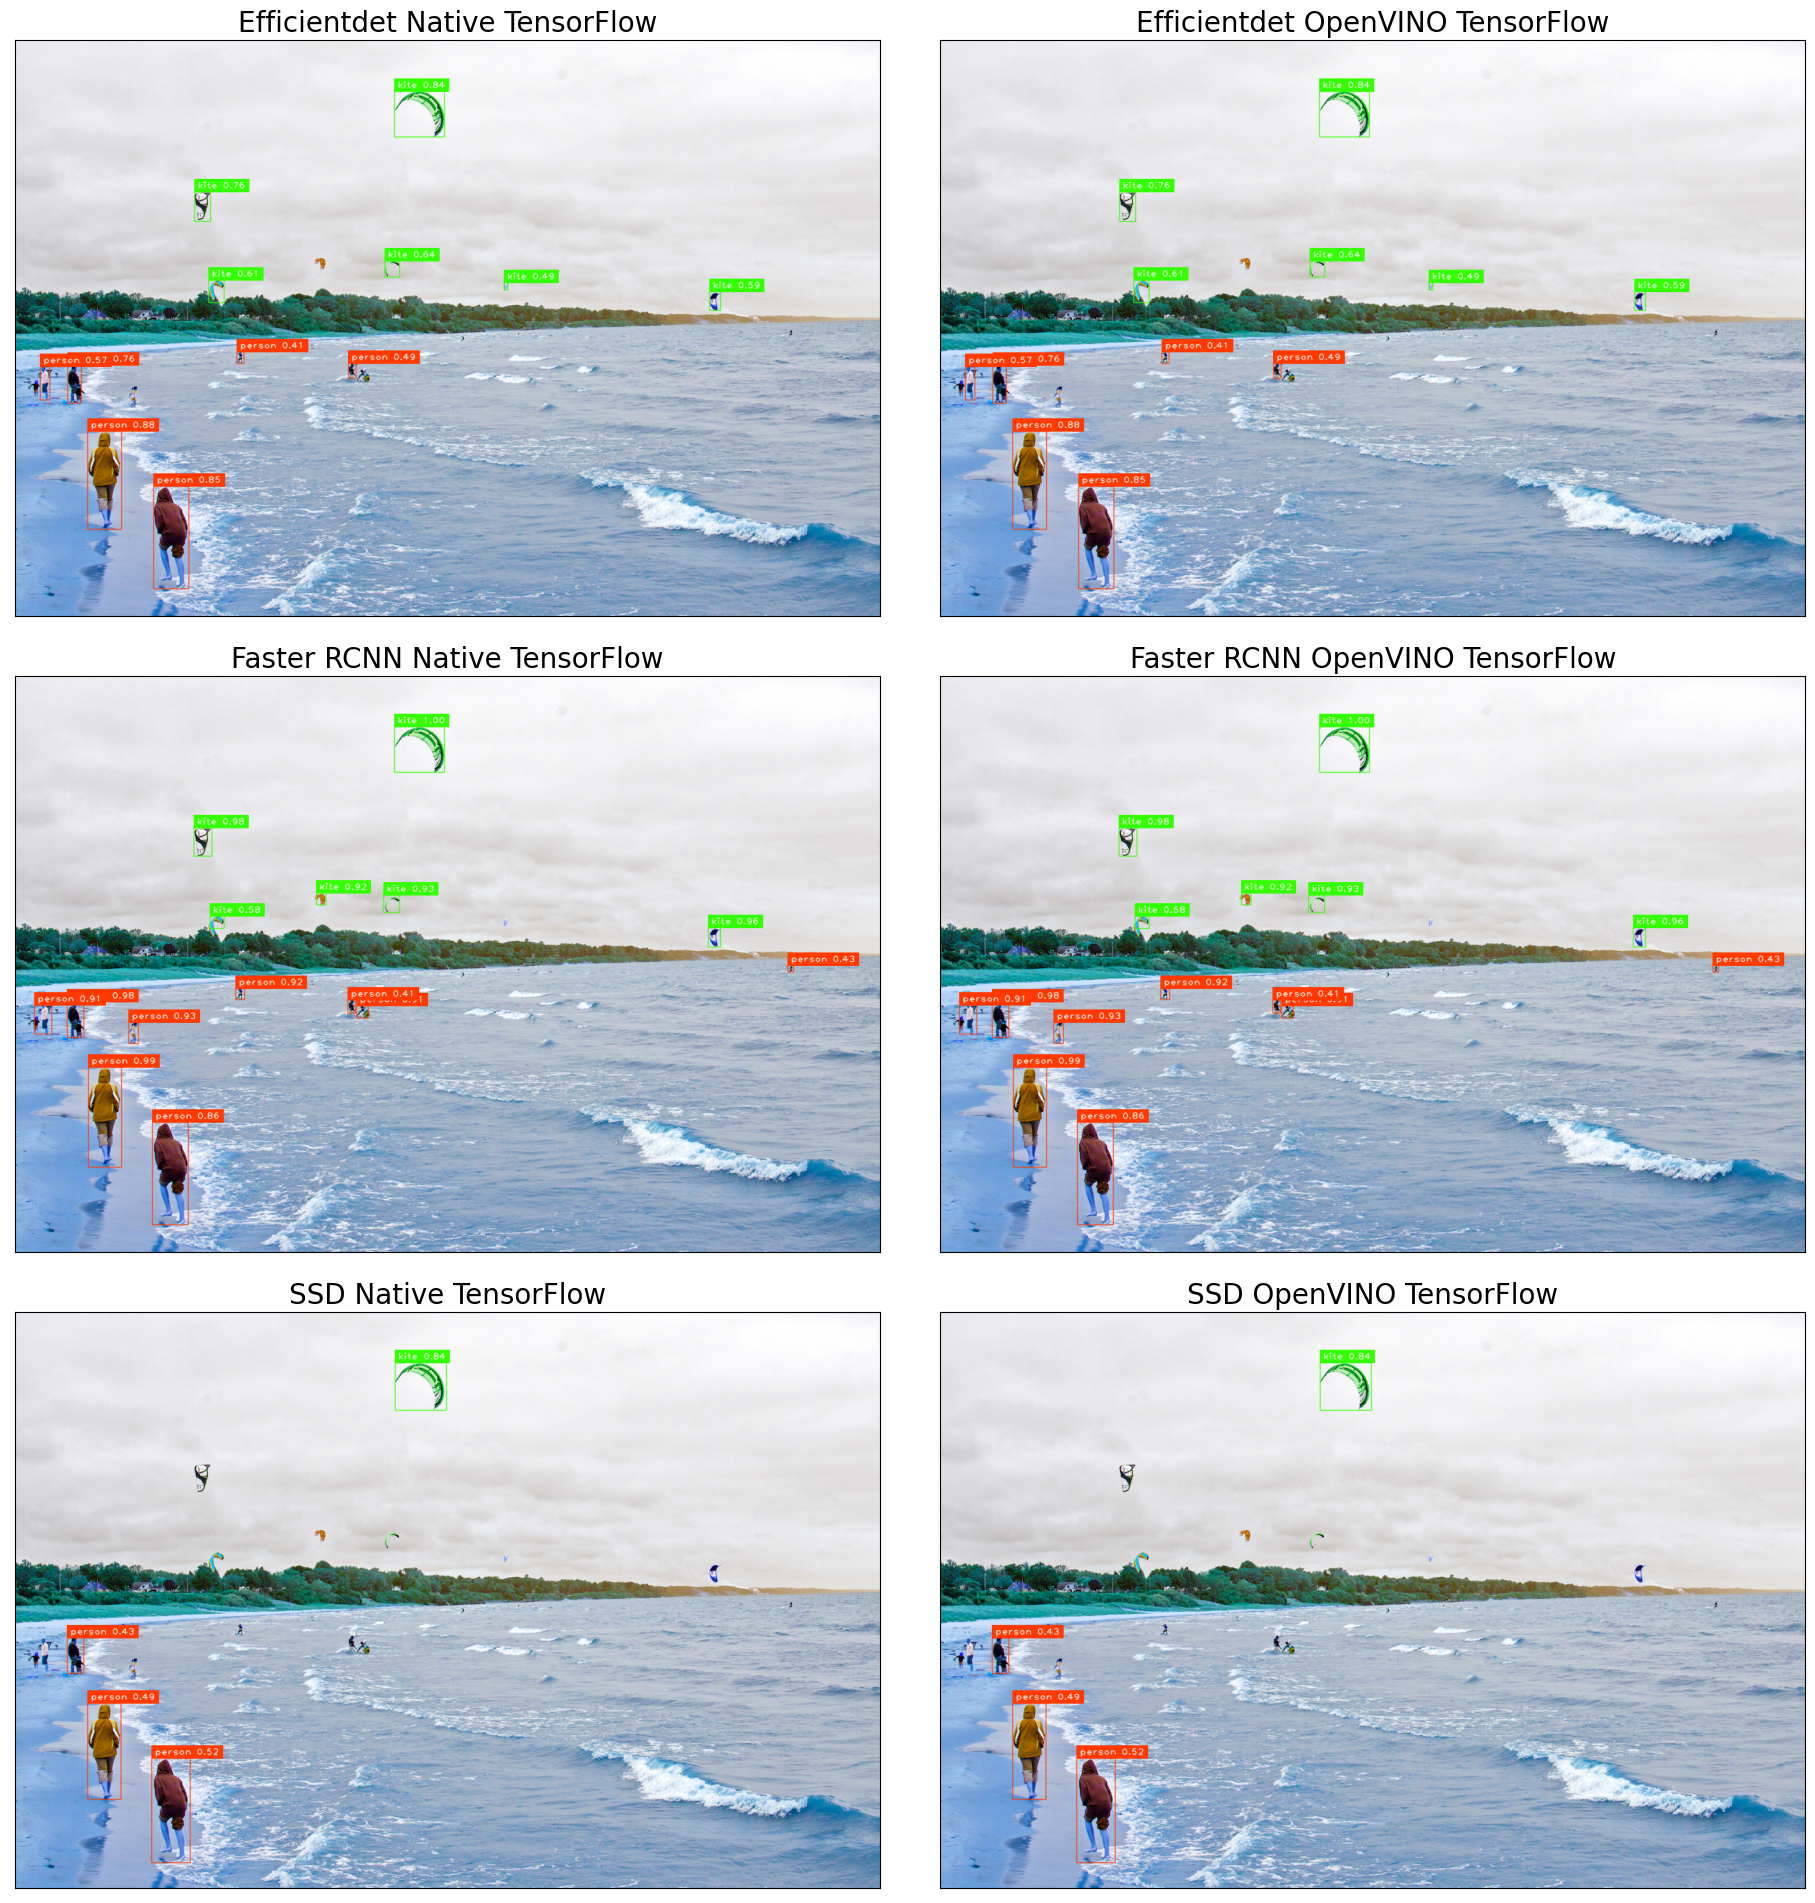

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
im_tf_efficinetdet = cv2.imread("output_images/"+ "efficientdet_d6_coco17_tpu-32_TF_CPU.png")
im_ovtf_efficinetdet = cv2.imread("output_images/"+ "efficientdet_d6_coco17_tpu-32_OVTF_CPU.png")
im_tf_faster_rcnn = cv2.imread("output_images/"+ "faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8_TF_CPU.png")
im_ovtf_faster_rcnn = cv2.imread("output_images/"+ "faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8_OVTF_CPU.png")
im_tf_ssd = cv2.imread("output_images/"+ "ssd_resnet50_v1_fpn_640x640_coco17_tpu-8_TF_CPU.png")
im_ovtf_ssd = cv2.imread("output_images/"+ "ssd_resnet50_v1_fpn_640x640_coco17_tpu-8_OVTF_CPU.png")

fig = plt.figure(figsize=(32,24))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
        nrows_ncols=(3, 2),  # creates 2x2 grid of axes
        axes_pad=0.6,  # pad between axes in inch.
        )
for i in range(6):
    grid[i].get_yaxis().set_ticks([])
    grid[i].get_xaxis().set_ticks([])

titles = ["Efficientdet Native TensorFlow", "Efficientdet OpenVINO TensorFlow","Faster RCNN Native TensorFlow", "Faster RCNN OpenVINO TensorFlow", "SSD Native TensorFlow","SSD OpenVINO TensorFlow"] 
for i in range(6):
    grid[i].set_title(titles[i], fontdict=None, fontsize=20, loc='center', color="k")

for ax, im in zip(grid, [im_tf_efficinetdet,im_ovtf_efficinetdet,im_tf_faster_rcnn,im_ovtf_faster_rcnn,im_tf_ssd,im_ovtf_ssd]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

# Let's plot the performance results

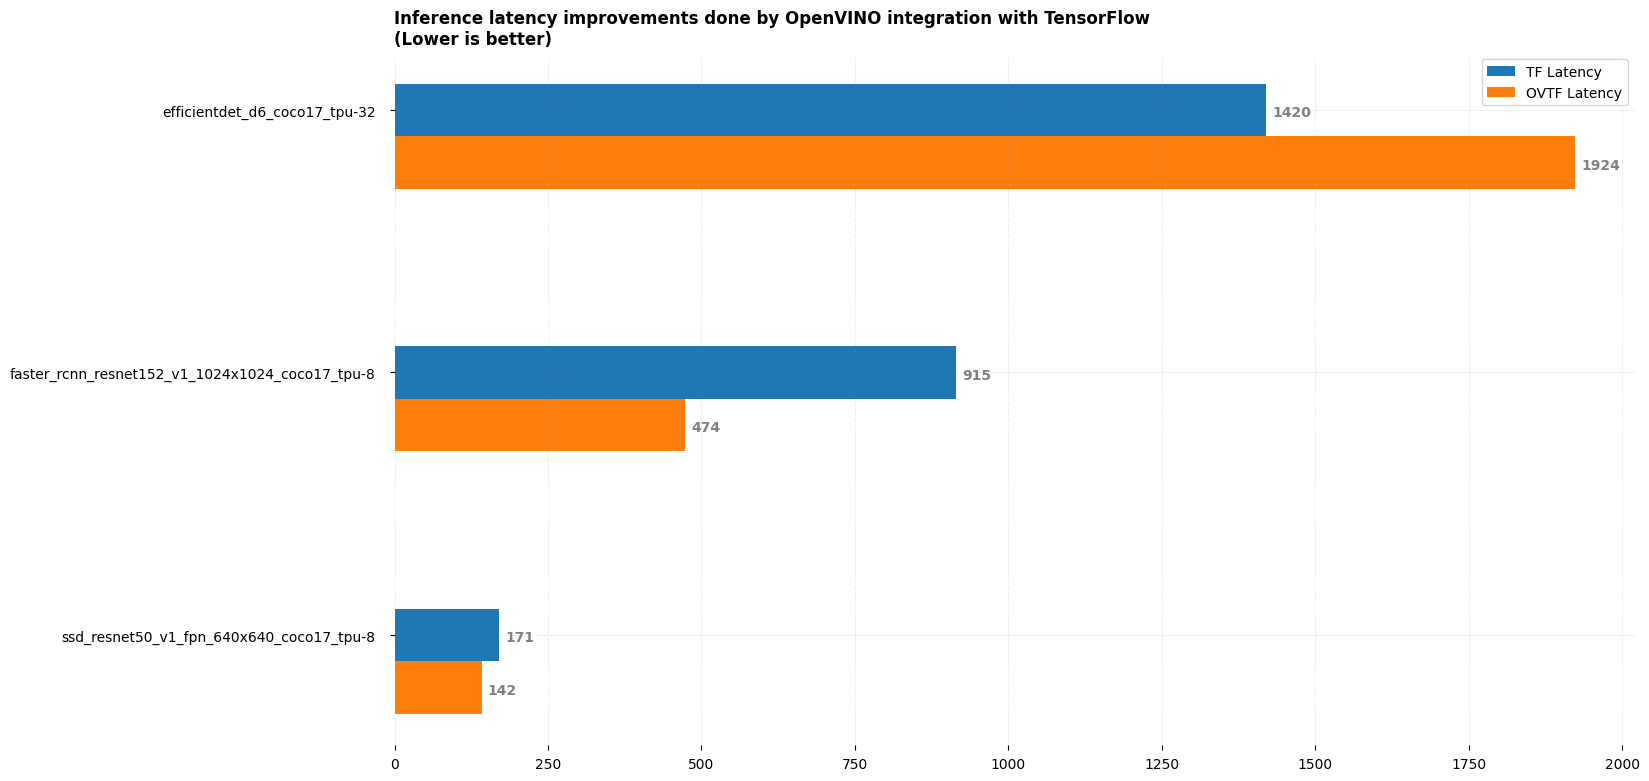

In [12]:
# Init a 16x9 plot
fig, ax = plt.subplots(figsize=(16, 9))

# Plot the values
Y = np.arange(len(ovtf_latency))
ax.barh(Y, list(tf_latency.values()), height=0.2)
ax.barh(Y+0.2, list(ovtf_latency.values()), height=0.2)

# Set Y-axis labels and add Legend
plt.yticks(Y, tf_latency.keys())
ax.legend(('TF Latency','OVTF Latency'))

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+10, i.get_y()+0.125,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('Inference latency improvements done by OpenVINO integration with TensorFlow\n(Lower is better)', loc='left', fontweight='bold')

plt.show()

## Notices & Disclaimers

Performance varies by use, configuration and other factors. Learn more at www.Intel.com/PerformanceIndex​.  

Your costs and results may vary. 

Intel technologies may require enabled hardware, software or service activation.
